In [1]:
import pandas as pd 
import numpy as np 
from datasets import load_dataset
import importlib
import re
from datetime import datetime, timezone
from collections import Counter
from pathlib import Path
from tqdm import tqdm
import glob
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel

import torch

#project dependences
import utils.text_functions as tf
from utils.store_data import store_raw_articles_parquet
importlib.reload(tf)

/home/onyxia/work/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'utils.text_functions' from '/home/onyxia/work/Modality-aware-transformer/utils/text_functions.py'>

## Raw data

Data from the [FNSPID dataset](https://huggingface.co/datasets/Zihan1004/FNSPID). (Raw data)


In [2]:
# visualisation test (pas besoin de run)

ds = load_dataset("Zihan1004/FNSPID", streaming=True) # true pour pas tout télécharger en local
#print(ds) 

split_name = list(ds.keys())[0]
it = iter(ds[split_name])

samples = [next(it) for _ in range(3)]
#print("Keys:", samples[0].keys())
#print("Example:", samples[0])

Repo card metadata block was not found. Setting CardData to empty.


In [ ]:
# récupère la base en brut en séparé pour faire du prétraitement par la suite

ds = load_dataset("Zihan1004/FNSPID", streaming=True)
split = ds["train"]

# Étapes universelles, sans hypothèse de causalité
split_raw = (
    split
    .map(tf.make_projector())       # garde colonnes utiles
    .map(tf.build_text_record)      # parse dt_utc + clean strings
    .filter(tf.is_valid_record)     # garde lignes minimales valides (dt_utc, stock_symbol, au moins un texte)
)

total = store_raw_articles_parquet(
    iterable=split_raw,
    out_dir="data/fnspid_raw",
    chunk_size=500_000,
    desc="Storing FNSPID raw"
)

print(f"Total rows written: {total}")

Repo card metadata block was not found. Setting CardData to empty.
Storing FNSPID raw: 8957329rows [2:51:27, 870.69rows/s]  


Total rows written: 8957329


In [36]:
RAW_DIR = Path("data/fnspid_raw")
f = RAW_DIR / "raw_00002.parquet"   

df = pd.read_parquet(f)
df.head()

,dt_utc,stock_symbol,url,publisher,author,title,article,textrank_summary,lexrank_summary,lsa_summary,luhn_summary
0,2010-04-20 00:00:00+00:00,PH,https://www.benzinga.com/markets/company-news/...,Monica Gerson,None,US Stocks Open Higher On Earnings Beat,None,None,None,None,None
1,2010-04-20 00:00:00+00:00,PH,https://www.benzinga.com/analyst-ratings/analy...,Benzinga Staff 5,None,"Jefferies & Company, Inc. Maintains Hold Ratin...",None,None,None,None,None
2,2010-04-20 00:00:00+00:00,PH,https://www.benzinga.com/markets/company-news/...,Daniel Hayden IV,None,Parker-Hannifin (PH) Profit Nearly Triples,None,None,None,None,None
3,2010-01-20 00:00:00+00:00,PH,https://www.benzinga.com/analyst-ratings/analy...,Benzinga Staff 5,None,Parker-Hannifin (PH) Optimally Priced,None,None,None,None,None
4,2010-01-19 00:00:00+00:00,PH,https://www.benzinga.com/trading-ideas/long-id...,Monica Gerson,None,Parker Hannifin Gives The Market A Pleasant Su...,None,None,None,None,None


In [ ]:
# voir le max/min des dates parmi la base de données

RAW_DIR = Path("data/fnspid_raw")
files = sorted(RAW_DIR.glob("raw_*.parquet"))

results = []

for f in files:
    df = pd.read_parquet(f, columns=["dt_utc"])
    df["dt_utc"] = pd.to_datetime(df["dt_utc"], utc=True, errors="coerce")

    min_dt = df["dt_utc"].min()
    max_dt = df["dt_utc"].max()

    results.append({
        "file": f.name,
        "min_dt": min_dt,
        "max_dt": max_dt,
        "rows": len(df)
    })

    print(f.name, "min:", min_dt, "max:", max_dt, "rows:", len(df))

raw_00000.parquet min: 2009-04-29 00:00:00+00:00 max: 2020-06-11 05:54:38+00:00 rows: 500000
raw_00001.parquet min: 2009-02-14 00:00:00+00:00 max: 2020-06-11 13:11:20+00:00 rows: 500000
raw_00002.parquet min: 2009-04-27 00:00:00+00:00 max: 2020-06-11 13:12:35+00:00 rows: 500000
raw_00003.parquet min: 2010-02-03 00:00:00+00:00 max: 2020-06-04 00:00:00+00:00 rows: 500000
raw_00004.parquet min: 1969-12-31 00:00:00+00:00 max: 2020-06-04 00:00:00+00:00 rows: 500000
raw_00005.parquet min: 2010-02-03 00:00:00+00:00 max: 2020-06-04 00:00:00+00:00 rows: 500000
raw_00006.parquet min: 2009-04-08 00:00:00+00:00 max: 2024-01-09 00:00:00+00:00 rows: 500000
raw_00007.parquet min: 2009-04-08 00:00:00+00:00 max: 2023-12-16 23:56:00+00:00 rows: 500000
raw_00008.parquet min: 2009-04-08 00:00:00+00:00 max: 2023-12-16 23:54:00+00:00 rows: 500000
raw_00009.parquet min: 2009-04-08 00:00:00+00:00 max: 2023-12-16 23:56:00+00:00 rows: 500000
raw_00010.parquet min: 2009-04-08 00:00:00+00:00 max: 2023-12-16 23:54

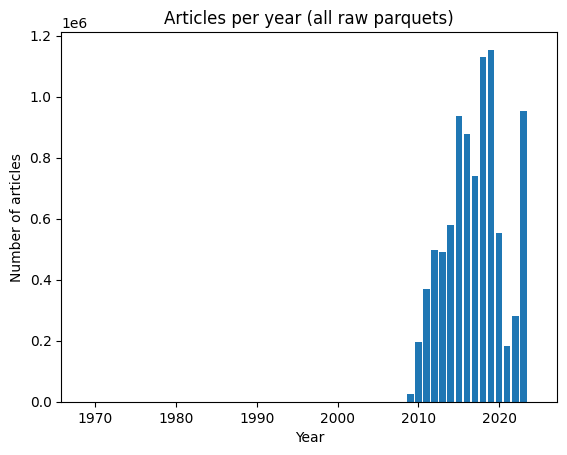

In [ ]:
RAW_DIR = Path("data/fnspid_raw")
files = sorted(RAW_DIR.glob("raw_*.parquet"))

year_counter = Counter()

for f in files:
    df = pd.read_parquet(f, columns=["dt_utc"])
    dt = pd.to_datetime(df["dt_utc"], utc=True, errors="coerce")
    year_counter.update(dt.dt.year.dropna().astype(int))

years = sorted(year_counter)
counts = [year_counter[y] for y in years]

plt.figure()
plt.bar(years, counts)
plt.xlabel("Year")
plt.ylabel("Number of articles")
plt.title("Articles per year (all raw parquets)")
plt.show()

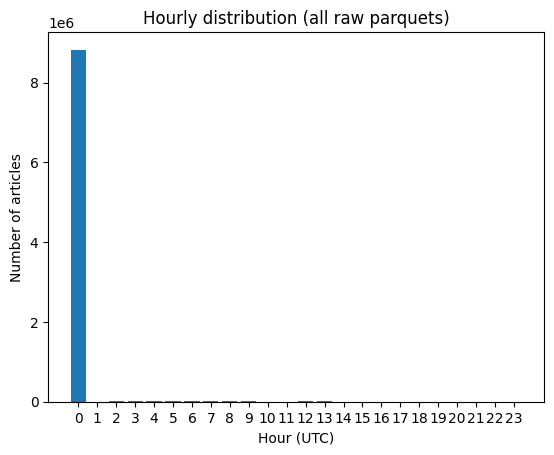

In [34]:
RAW_DIR = Path("data/fnspid_raw")
files = sorted(RAW_DIR.glob("raw_*.parquet"))

hour_counter = Counter()

for f in files:
    df = pd.read_parquet(f, columns=["dt_utc"])
    dt = pd.to_datetime(df["dt_utc"], utc=True, errors="coerce")
    hour_counter.update(dt.dt.hour.dropna().astype(int))

hours = list(range(24))
counts = [hour_counter.get(h, 0) for h in hours]

plt.figure()
plt.bar(hours, counts)
plt.xlabel("Hour (UTC)")
plt.ylabel("Number of articles")
plt.title("Hourly distribution (all raw parquets)")
plt.xticks(range(0, 24))
plt.show()

In [17]:
# regarde quand est ce que l'article est dispo

RAW_DIR = Path("data/fnspid_raw")
files = sorted(RAW_DIR.glob("raw_*.parquet"))

results = []

for f in files:
    # On lit uniquement la colonne 'article'
    df = pd.read_parquet(f, columns=["article"])

    n_total = len(df)
    n_not_none = df["article"].notna().sum()
    n_none = n_total - n_not_none

    results.append({
        "parquet": f.name,
        "total": n_total,
        "article_not_none": n_not_none,
        "article_none": n_none,
        "share_not_none": n_not_none / n_total if n_total > 0 else 0.0,
    })

    print(
        f.name,
        "| total:", n_total,
        "| article != None:", n_not_none,
        "| article == None:", n_none,
        "| share:", round(n_not_none / n_total, 4)
    )

raw_00000.parquet | total: 500000 | article != None: 0 | article == None: 500000 | share: 0.0
raw_00001.parquet | total: 500000 | article != None: 0 | article == None: 500000 | share: 0.0
raw_00002.parquet | total: 500000 | article != None: 0 | article == None: 500000 | share: 0.0
raw_00003.parquet | total: 500000 | article != None: 0 | article == None: 500000 | share: 0.0
raw_00004.parquet | total: 500000 | article != None: 0 | article == None: 500000 | share: 0.0
raw_00005.parquet | total: 500000 | article != None: 0 | article == None: 500000 | share: 0.0
raw_00006.parquet | total: 500000 | article != None: 267227 | article == None: 232773 | share: 0.5345
raw_00007.parquet | total: 500000 | article != None: 500000 | article == None: 0 | share: 1.0
raw_00008.parquet | total: 500000 | article != None: 500000 | article == None: 0 | share: 1.0
raw_00009.parquet | total: 500000 | article != None: 499998 | article == None: 2 | share: 1.0
raw_00010.parquet | total: 500000 | article != None:

In [18]:
# regarde quand est ce que le titre est dispo 

RAW_DIR = Path("data/fnspid_raw")
files = sorted(RAW_DIR.glob("raw_*.parquet"))

results = []

for f in files:
    # On lit uniquement la colonne 'article'
    df = pd.read_parquet(f, columns=["title"])

    n_total = len(df)
    n_not_none = df["title"].notna().sum()
    n_none = n_total - n_not_none

    results.append({
        "parquet": f.name,
        "total": n_total,
        "title_not_none": n_not_none,
        "title_none": n_none,
        "share_not_none": n_not_none / n_total if n_total > 0 else 0.0,
    })

    print(
        f.name,
        "| total:", n_total,
        "| title_summary != None:", n_not_none,
        "| title_summary == None:", n_none,
        "| share:", round(n_not_none / n_total, 4)
    )

raw_00000.parquet | total: 500000 | title_summary != None: 500000 | title_summary == None: 0 | share: 1.0
raw_00001.parquet | total: 500000 | title_summary != None: 500000 | title_summary == None: 0 | share: 1.0
raw_00002.parquet | total: 500000 | title_summary != None: 500000 | title_summary == None: 0 | share: 1.0
raw_00003.parquet | total: 500000 | title_summary != None: 500000 | title_summary == None: 0 | share: 1.0
raw_00004.parquet | total: 500000 | title_summary != None: 500000 | title_summary == None: 0 | share: 1.0
raw_00005.parquet | total: 500000 | title_summary != None: 500000 | title_summary == None: 0 | share: 1.0
raw_00006.parquet | total: 500000 | title_summary != None: 500000 | title_summary == None: 0 | share: 1.0
raw_00007.parquet | total: 500000 | title_summary != None: 500000 | title_summary == None: 0 | share: 1.0
raw_00008.parquet | total: 500000 | title_summary != None: 500000 | title_summary == None: 0 | share: 1.0
raw_00009.parquet | total: 500000 | title_summ

In [22]:
# regarde quand est-ce que l'article est dispo (heure != 00)

RAW_DIR = Path("data/fnspid_raw")
files = sorted(RAW_DIR.glob("raw_*.parquet"))

results = []

for f in files:
    # On lit uniquement la colonne dt_utc
    df = pd.read_parquet(f, columns=["dt_utc"])
    dt = pd.to_datetime(df["dt_utc"], utc=True, errors="coerce")

    n_total = len(dt)

    # heures valides
    hours = dt.dt.hour

    n_not_midnight = (hours != 0).sum()
    n_midnight = (hours == 0).sum()

    results.append({
        "parquet": f.name,
        "total": n_total,
        "hour_not_00": int(n_not_midnight),
        "hour_00": int(n_midnight),
        "share_not_00": n_not_midnight / n_total if n_total > 0 else 0.0,
    })

    print(
        f.name,
        "| total:", n_total,
        "| hour != 00:", int(n_not_midnight),
        "| hour == 00:", int(n_midnight),
        "| share:", round(n_not_midnight / n_total, 4)
    )

raw_00000.parquet | total: 500000 | hour != 00: 18861 | hour == 00: 481139 | share: 0.0377
raw_00001.parquet | total: 500000 | hour != 00: 19379 | hour == 00: 480621 | share: 0.0388
raw_00002.parquet | total: 500000 | hour != 00: 16249 | hour == 00: 483751 | share: 0.0325
raw_00003.parquet | total: 500000 | hour != 00: 0 | hour == 00: 500000 | share: 0.0
raw_00004.parquet | total: 500000 | hour != 00: 0 | hour == 00: 500000 | share: 0.0
raw_00005.parquet | total: 500000 | hour != 00: 0 | hour == 00: 500000 | share: 0.0
raw_00006.parquet | total: 500000 | hour != 00: 3565 | hour == 00: 496435 | share: 0.0071
raw_00007.parquet | total: 500000 | hour != 00: 6345 | hour == 00: 493655 | share: 0.0127
raw_00008.parquet | total: 500000 | hour != 00: 5055 | hour == 00: 494945 | share: 0.0101
raw_00009.parquet | total: 500000 | hour != 00: 7086 | hour == 00: 492914 | share: 0.0142
raw_00010.parquet | total: 500000 | hour != 00: 3050 | hour == 00: 496950 | share: 0.0061
raw_00011.parquet | total

## Processing data

In [5]:
# Dossiers

IN_DIR = Path("data/fnspid_raw")
OUT_DIR = Path("data/fnspid_processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

raw_files = sorted(IN_DIR.glob("raw_*.parquet"))

print(f"Found {len(raw_files)} raw parquet files")


# Traitement

for i, f in enumerate(tqdm(raw_files, desc="Processing raw -> processed", unit="file")):
    df = pd.read_parquet(f)

    # dt_utc -> datetime UTC
    df["dt_utc"] = pd.to_datetime(df["dt_utc"], utc=True, errors="coerce")

    # effective_date = prochain jour de trading NYSE
    df["effective_date"] = df["dt_utc"].dt.date.apply(
        lambda d: tf.next_trading_day_nyse(d).isoformat()
        if pd.notna(d) else None
    )

    # Texte final : headline uniquement
    df["text"] = df["title"]
    df["text_source"] = "title"
    df["text_len"] = df["text"].fillna("").str.split().str.len()

    # Filtres finaux
    df = df[
        df["effective_date"].notna()
        & df["stock_symbol"].notna()
        & df["text"].notna()
        & (df["text_len"] >= 3)
    ].copy()

    # Dédoublonnage (URL > fallback hash) (on enlève les doubles url si pas dispo (titre, time, entreprise) similaireq)
    df["dedup_key"] = df.apply(tf.make_dedup_key, axis=1)
    df = (
        df
        .drop_duplicates(subset=["dedup_key"], keep="first")
        .drop(columns=["dedup_key"])
    )

    # Colonnes finales
    df = df[
        [
            "effective_date",
            "stock_symbol",
            "dt_utc",
            "text",
            "text_source",
            "text_len",
            "publisher",
            "url",
        ]
    ]

    # Écriture
    df.to_parquet(
        OUT_DIR / f"processed_{i:05d}.parquet",
        index=False
    )

print("Processing completed successfully")

Found 0 raw parquet files


Processing raw -> processed: 0file [00:00, ?file/s]

Processing completed successfully


In [6]:
RAW_DIR = Path("data/fnspid_processed")
f = RAW_DIR / "processed_00002.parquet"   

df = pd.read_parquet(f)
df.head()

,effective_date,stock_symbol,dt_utc,text,text_source,text_len,publisher,url
0,2010-04-21,PH,2010-04-20 00:00:00+00:00,US Stocks Open Higher On Earnings Beat,title,7,Monica Gerson,https://www.benzinga.com/markets/company-news/...
1,2010-04-21,PH,2010-04-20 00:00:00+00:00,"Jefferies & Company, Inc. Maintains Hold Ratin...",title,11,Benzinga Staff 5,https://www.benzinga.com/analyst-ratings/analy...
2,2010-04-21,PH,2010-04-20 00:00:00+00:00,Parker-Hannifin (PH) Profit Nearly Triples,title,5,Daniel Hayden IV,https://www.benzinga.com/markets/company-news/...
3,2010-01-21,PH,2010-01-20 00:00:00+00:00,Parker-Hannifin (PH) Optimally Priced,title,4,Benzinga Staff 5,https://www.benzinga.com/analyst-ratings/analy...
4,2010-01-20,PH,2010-01-19 00:00:00+00:00,Parker Hannifin Gives The Market A Pleasant Su...,title,8,Monica Gerson,https://www.benzinga.com/trading-ideas/long-id...


In [8]:
DATA_DIR = Path("data/fnspid_processed")
files = sorted(DATA_DIR.glob("processed_*.parquet"))
print(f"{len(files)} parquet files found")

18 parquet files found


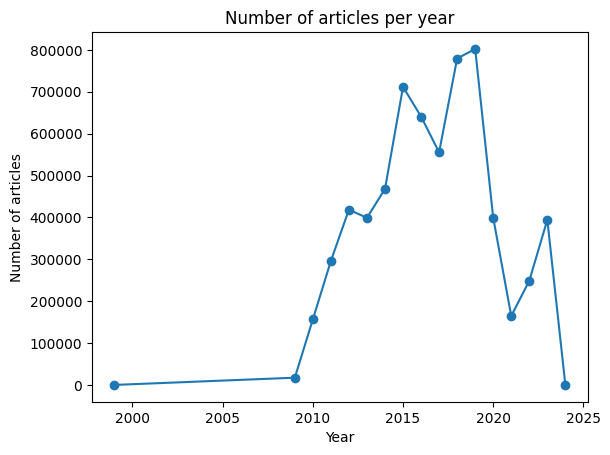

In [12]:
year_counts = Counter()

for f in files:
    df = pd.read_parquet(f, columns=["effective_date"])
    years = pd.to_datetime(df["effective_date"], errors="coerce").dt.year
    year_counts.update(years.dropna().astype(int))

years = sorted(year_counts)
counts = [year_counts[y] for y in years]

plt.figure()
plt.plot(years, counts, marker="o")
plt.xlabel("Year")
plt.ylabel("Number of articles")
plt.title("Number of articles per year")
plt.show()

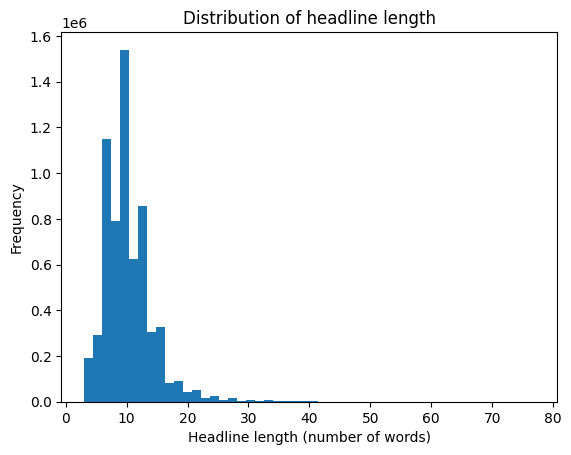

In [40]:
lengths = []

for f in files:
    df = pd.read_parquet(f, columns=["text_len"])
    lengths.extend(df["text_len"].dropna().tolist())

plt.figure()
plt.hist(lengths, bins=50)
plt.xlabel("Headline length (number of words)")
plt.ylabel("Frequency")
plt.title("Distribution of headline length")
plt.show()

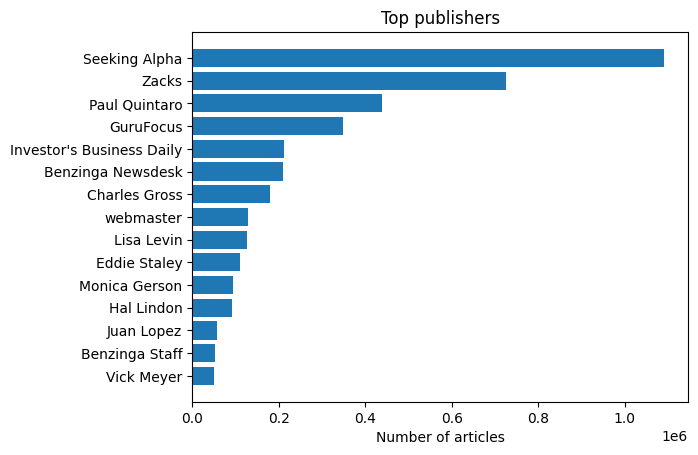

In [42]:
publisher_counter = Counter()

for f in files:
    df = pd.read_parquet(f, columns=["publisher"])
    publisher_counter.update(df["publisher"].dropna())

top = publisher_counter.most_common(15)
labels, values = zip(*top)

plt.figure()
plt.barh(labels[::-1], values[::-1])
plt.xlabel("Number of articles")
plt.title("Top publishers")
plt.show()

In [10]:
total = 0
for f in files:
    n = len(pd.read_parquet(f, columns=["text"]))
    total += n
    print(f"{f.name:20s} | rows: {n}")

print("-" * 40)
print("Total rows:", total)

processed_00000.parquet | rows: 363826
processed_00001.parquet | rows: 368680
processed_00002.parquet | rows: 388161
processed_00003.parquet | rows: 347239
processed_00004.parquet | rows: 351252
processed_00005.parquet | rows: 350761
processed_00006.parquet | rows: 382221
processed_00007.parquet | rows: 347529
processed_00008.parquet | rows: 303483
processed_00009.parquet | rows: 353391
processed_00010.parquet | rows: 374280
processed_00011.parquet | rows: 391568
processed_00012.parquet | rows: 363658
processed_00013.parquet | rows: 370710
processed_00014.parquet | rows: 383198
processed_00015.parquet | rows: 341612
processed_00016.parquet | rows: 350216
processed_00017.parquet | rows: 319343
----------------------------------------
Total rows: 6451128


## Features 

### Sentiment analysis

In [23]:
# Paramètres

data_dir = Path("data/fnspid_processed")
out_dir = Path("data/fnspid_sentiment")
out_dir.mkdir(parents=True, exist_ok=True)

batch_size = 512          # nombre de passage par le modèle
device = "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
# Modèle FinBERT

model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name) #tokenizer associé au modèle
model = AutoModelForSequenceClassification.from_pretrained(model_name) # charger reseau de neurone FinBert
model.to(device)
model.eval() #pas de train juste prediction

label_map = {0: "negative", 1: "neutral", 2: "positive"}

In [25]:
# Boucle sur les parquets

files = sorted(data_dir.glob("processed_*.parquet"))

for i, f in enumerate(tqdm(files, desc="FinBERT sentiment", unit="file")):
    df = pd.read_parquet(f, columns=[
        "effective_date", "stock_symbol", "dt_utc",
        "text", "publisher", "url"
    ]) 

    texts = df["text"].astype(str).tolist()

    pos_scores, neg_scores, neu_scores, sent_scores = [], [], [], []

    print(f'We are on :', device)

    # Batch inference
    for j in range(0, len(texts), batch_size):
        batch_texts = texts[j:j + batch_size] # parcourt toute la base selon le batch size
        
        enc = tokenizer(
            batch_texts,
            padding=True, # remplissage quand token petit
            truncation=True, #coupure quand trop grand
            max_length=64,   # headlines courts
            return_tensors="pt"
        ).to(device)

        with torch.no_grad(): #on entraine pas (pas de calcul de gradient)
            outputs = model(**enc)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1).cpu().numpy()

        # ordre FinBERT: [neg, neu, pos]
        neg = probs[:, 0]
        neu = probs[:, 1]
        pos = probs[:, 2]

        neg_scores.extend(neg)
        neu_scores.extend(neu)
        pos_scores.extend(pos)
        sent_scores.extend(pos - neg) # choix particulier naif parce que donne une direction mais peut être changé

    # Ajout des colonnes sentiment
    df["sent_neg"] = neg_scores
    df["sent_neu"] = neu_scores
    df["sent_pos"] = pos_scores
    df["sent_score"] = sent_scores

    # Écriture
    df.to_parquet(
        out_dir / f"sentiment_{i:05d}.parquet",
        index=False
    )

print("FinBERT sentiment extraction completed")

FinBERT sentiment:   0%|          | 0/18 [00:00<?, ?file/s]

We are on : cuda


FinBERT sentiment:   6%|▌         | 1/18 [19:24<5:29:59, 1164.69s/file]

We are on : cuda


FinBERT sentiment:  11%|█         | 2/18 [38:56<5:11:46, 1169.14s/file]

We are on : cuda


FinBERT sentiment:  17%|█▋        | 3/18 [57:52<4:48:26, 1153.75s/file]

We are on : cuda


FinBERT sentiment:  22%|██▏       | 4/18 [1:09:18<3:46:07, 969.13s/file]

We are on : cuda


FinBERT sentiment:  28%|██▊       | 5/18 [1:20:51<3:08:26, 869.69s/file]

We are on : cuda


FinBERT sentiment:  33%|███▎      | 6/18 [1:32:37<2:42:45, 813.82s/file]

We are on : cuda


FinBERT sentiment:  39%|███▉      | 7/18 [1:47:03<2:32:20, 830.92s/file]

We are on : cuda


FinBERT sentiment:  44%|████▍     | 8/18 [2:01:29<2:20:21, 842.13s/file]

We are on : cuda


FinBERT sentiment:  50%|█████     | 9/18 [2:14:05<2:02:17, 815.29s/file]

We are on : cuda


FinBERT sentiment:  56%|█████▌    | 10/18 [2:28:50<1:51:32, 836.61s/file]

We are on : cuda


FinBERT sentiment:  61%|██████    | 11/18 [2:44:09<1:40:34, 862.04s/file]

We are on : cuda


FinBERT sentiment:  67%|██████▋   | 12/18 [3:03:03<1:34:27, 944.61s/file]

We are on : cuda


FinBERT sentiment:  72%|███████▏  | 13/18 [3:22:25<1:24:12, 1010.52s/file]

We are on : cuda


FinBERT sentiment:  78%|███████▊  | 14/18 [3:42:13<1:10:57, 1064.28s/file]

We are on : cuda


FinBERT sentiment:  83%|████████▎ | 15/18 [3:57:10<50:41, 1013.83s/file]  

We are on : cuda


FinBERT sentiment:  89%|████████▉ | 16/18 [4:08:29<30:26, 913.01s/file] 

We are on : cuda


FinBERT sentiment:  94%|█████████▍| 17/18 [4:20:14<14:10, 850.38s/file]

We are on : cuda


FinBERT sentiment: 100%|██████████| 18/18 [4:30:45<00:00, 902.51s/file]

FinBERT sentiment extraction completed


### Embedding

In [2]:
# Dossiers

data_dir = Path("data/fnspid_processed")
out_dir = Path("data/fnspid_embeddings")
out_dir.mkdir(parents=True, exist_ok=True)

# Modèle
model_name = "ProsusAI/finbert"

# Config
batch_size = 512        # GPU: 128–512 / CPU: 16–64
max_len = 64            # headlines
pooling = "mean"        # "mean" (recommandé)

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if device == "cuda" else torch.float32

In [3]:
#Chargement tokenizer + encodeur (pas la tête de classification)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [4]:
# vecteur d'une headline c'est la moyenne des vecteur de chaque token

def mean_pooling(last_hidden_state, attention_mask):
    """
    last_hidden_state: (B, L, 768)
    attention_mask:    (B, L)
    return:            (B, 768)
    """
    mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state)
    summed = (last_hidden_state * mask).sum(dim=1)
    counts = mask.sum(dim=1).clamp(min=1e-9)
    return summed / counts

In [5]:
@torch.no_grad()
def encode_texts(texts):
    enc = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

    enc = {k: v.to(device) for k, v in enc.items()}

    with torch.autocast(device_type="cuda", dtype=dtype, enabled=(device == "cuda")):
        outputs = model(**enc)
        emb = mean_pooling(outputs.last_hidden_state, enc["attention_mask"])

    return emb.cpu().float().numpy()  # (B, 768)

In [12]:
# traite les fichiers par partie

files = sorted(data_dir.glob("processed_*.parquet"))
print("Total files:", len(files))

start_idx = 0   # ex: 3
end_idx   = 1   # ex: 6 -> traitera 3,4,5

for i in tqdm(range(start_idx, end_idx), desc="Embedding selected files", unit="file"):
    f = files[i]
    out_file = out_dir / f"embed_{i:05d}.parquet"

    if out_file.exists():
        print("Skip:", out_file.name)
        continue

    print(f"\nProcessing {i}: {f.name}")

    df = pd.read_parquet(
        f,
        columns=["effective_date", "stock_symbol", "dt_utc", "text", "publisher", "url"]
    )
    df["text"] = df["text"].astype(str).fillna("")
    texts = df["text"].tolist()

    embeddings = np.zeros((len(df), 768), dtype=np.float32)

    for start in tqdm(range(0, len(texts), batch_size), desc=f"Batches ({f.name})", unit="batch", leave=False):
        batch_texts = texts[start:start + batch_size]
        emb = encode_texts(batch_texts)
        embeddings[start:start + len(batch_texts)] = emb

    df["emb"] = list(embeddings.astype(np.float16))
    df.to_parquet(out_file, index=False)

    print("Saved:", out_file)

Total files: 1


Embedding selected files:   0%|          | 0/1 [00:00<?, ?file/s]


Processing 0: processed_00017.parquet


Embedding selected files: 100%|██████████| 1/1 [02:47<00:00, 167.80s/file]

Saved: data/fnspid_embeddings/embed_00000.parquet
